Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
import funs
from Lorenz_Attractor import sample_traj_lorenz

# Sample from latent Lorenz attractor:


In [2]:
Time = 100
neuron_num = 30
traj = sample_traj_lorenz(T = Time,speed_up = 4,initial_offset = 10000)

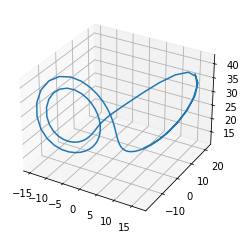

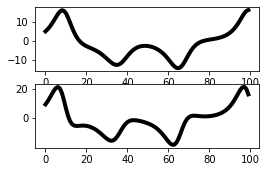

In [3]:
# We sample 20 latent trajectories and project them into 50 output neurons using random weights:

Factor = np.random.randn(3,neuron_num)

NRep=1
output = np.zeros((NRep,Time,neuron_num))

for i in range(NRep):
    traj = sample_traj_lorenz(T = Time,speed_up = 4,initial_offset = 10000)
    output[i,:,:] = traj @ Factor
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj[:,0],traj[:,1],traj[:,2])
plt.figure(figsize=(4, 4))
ax1 = plt.subplot(311)
ax1.plot(traj[:, 0], lw=4, color='k')

ax2 = plt.subplot(312, sharex=ax1)
ax2.plot(traj[:, 1], lw=4, color='k')    
output = output.astype('float32')

# Z score output:
output=output.reshape(Time*NRep,neuron_num)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(NRep,Time,neuron_num)

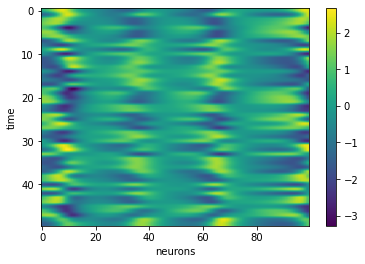

In [4]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('neurons')
plt.ylabel('time')
plt.colorbar()
plt.show()

In [5]:
dataset = tf.data.Dataset.from_tensor_slices((output))
dataset = dataset.shuffle(20, reshuffle_each_iteration=True)

# Autoencoder Model

In [6]:
tf.keras.backend.clear_session()

In [7]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [8]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z

In [9]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=3,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        self.dense_output = tf.keras.layers.Dense(num_input_neuron, activation=None)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        xo = self.dense_output(x)
        return xo, x

In [10]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=Time,
                 num_input_neuron=neuron_num,
                 num_factor=3,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)[0]
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed
    def latent(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        latent = self.decoder(z)[1]
        return latent

In [11]:
BATCH_SIZE = 20
batched_dataset = dataset.batch(BATCH_SIZE)

In [12]:
vae = VariationalAutoEncoder(latent_dim=64,
                             num_gru_unit=128,
                             sequence_length=Time,
                             num_input_neuron=neuron_num,
                             num_factor=3)

# Train Model

In [13]:
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()

#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [14]:
KL_penalty = np.linspace(0,1,4)

In [15]:
epochs = 300

for i,kl_ in enumerate(KL_penalty):
    
    if i > 0:
        break
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:
                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))

Start of epoch 0
step 0: mean loss = 1.0010633
Start of epoch 1
step 0: mean loss = 1.0028878
Start of epoch 2
step 0: mean loss = 1.002017
Start of epoch 3
step 0: mean loss = 1.0015268
Start of epoch 4
step 0: mean loss = 1.0013024
Start of epoch 5
step 0: mean loss = 1.0009423
Start of epoch 6
step 0: mean loss = 1.0002828
Start of epoch 7
step 0: mean loss = 1.0001347
Start of epoch 8
step 0: mean loss = 1.0003307
Start of epoch 9
step 0: mean loss = 0.99966776
Start of epoch 10
step 0: mean loss = 0.9988264
Start of epoch 11
step 0: mean loss = 0.99794585
Start of epoch 12
step 0: mean loss = 0.9967645
Start of epoch 13
step 0: mean loss = 0.9959312
Start of epoch 14
step 0: mean loss = 0.99484175
Start of epoch 15
step 0: mean loss = 0.9937972
Start of epoch 16
step 0: mean loss = 0.9923347
Start of epoch 17
step 0: mean loss = 0.9910412
Start of epoch 18
step 0: mean loss = 0.98961467
Start of epoch 19
step 0: mean loss = 0.98817444
Start of epoch 20
step 0: mean loss = 0.986810

step 0: mean loss = 0.7060401
Start of epoch 169
step 0: mean loss = 0.703809
Start of epoch 170
step 0: mean loss = 0.70164037
Start of epoch 171
step 0: mean loss = 0.6994104
Start of epoch 172
step 0: mean loss = 0.69721806
Start of epoch 173
step 0: mean loss = 0.6950302
Start of epoch 174
step 0: mean loss = 0.6928087
Start of epoch 175
step 0: mean loss = 0.69064236
Start of epoch 176
step 0: mean loss = 0.6886146
Start of epoch 177
step 0: mean loss = 0.68720365
Start of epoch 178
step 0: mean loss = 0.68540543
Start of epoch 179
step 0: mean loss = 0.68340147
Start of epoch 180
step 0: mean loss = 0.68147933
Start of epoch 181
step 0: mean loss = 0.6794619
Start of epoch 182
step 0: mean loss = 0.6776516
Start of epoch 183
step 0: mean loss = 0.6757452
Start of epoch 184
step 0: mean loss = 0.6738298
Start of epoch 185
step 0: mean loss = 0.6719873
Start of epoch 186
step 0: mean loss = 0.6700197
Start of epoch 187
step 0: mean loss = 0.6681171
Start of epoch 188
step 0: mean l

<ipython-input-18-d71df927e928>:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


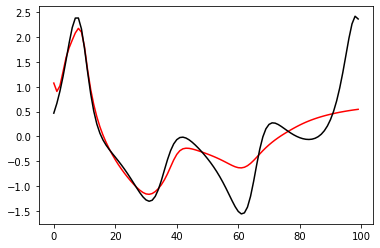

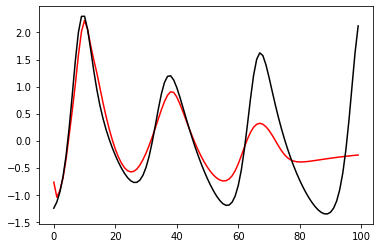

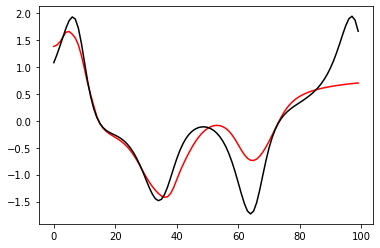

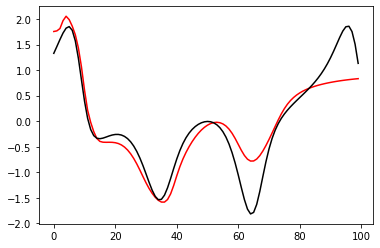

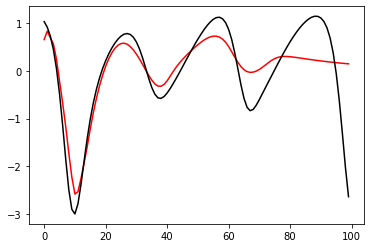

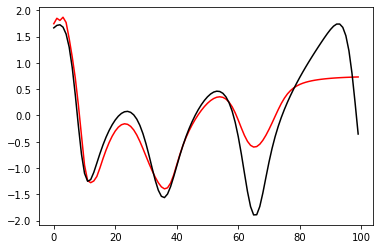

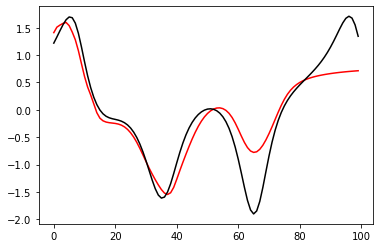

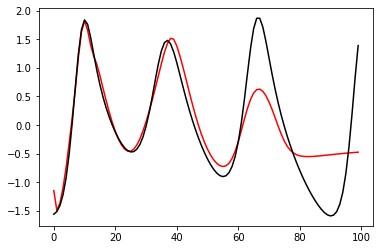

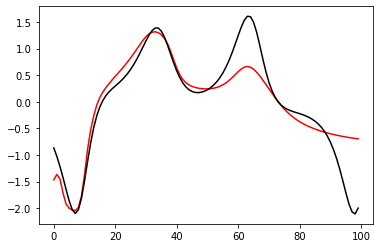

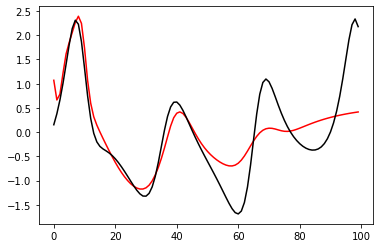

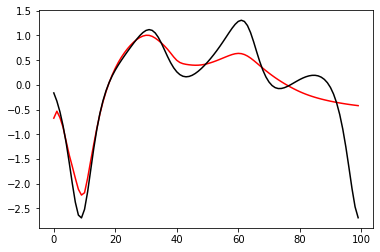

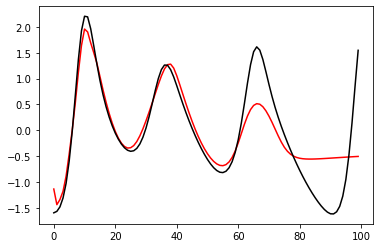

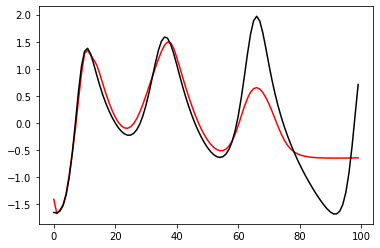

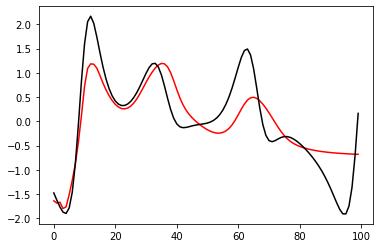

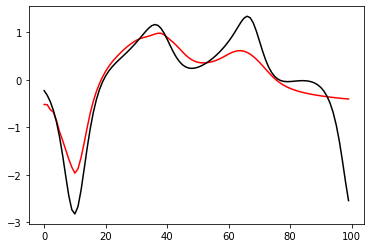

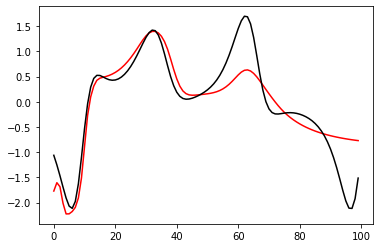

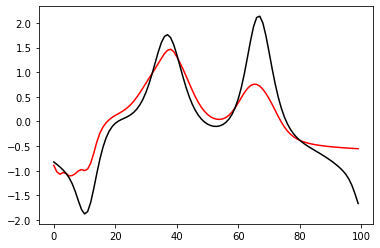

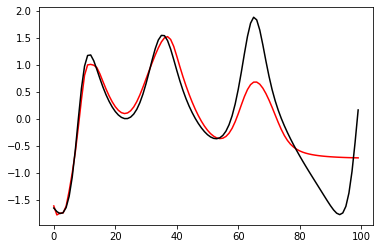

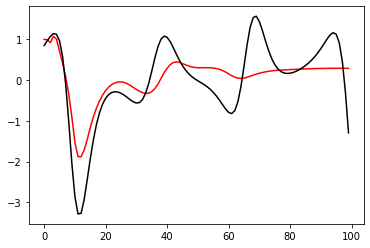

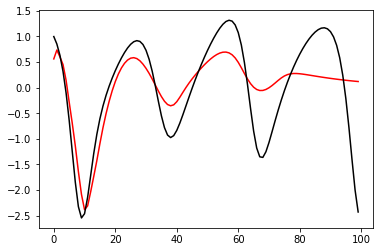

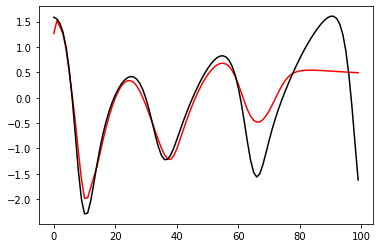

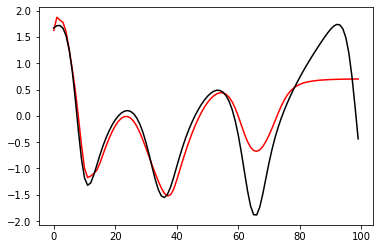

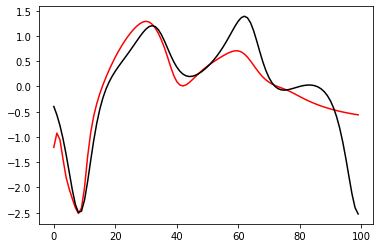

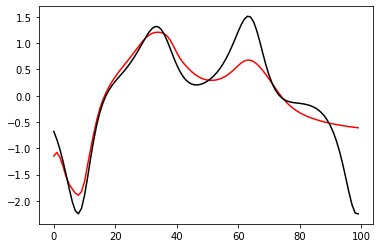

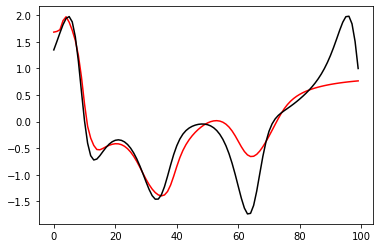

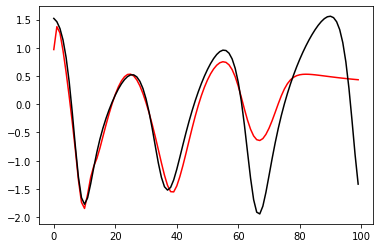

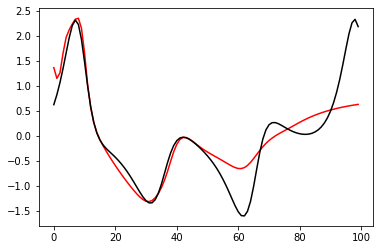

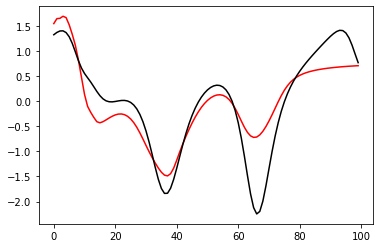

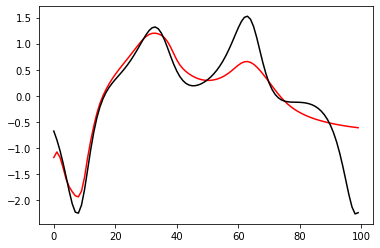

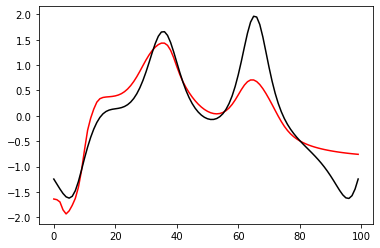

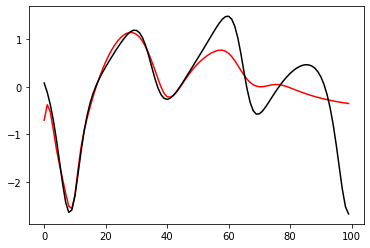

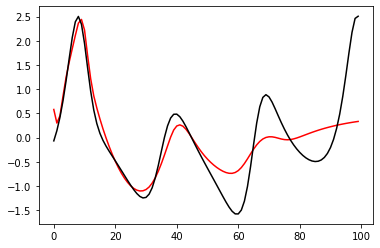

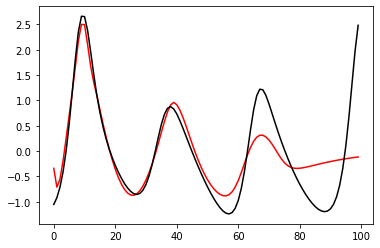

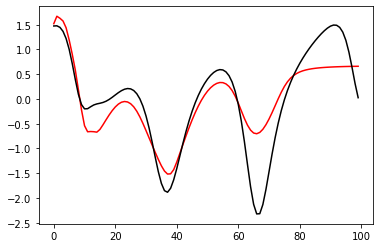

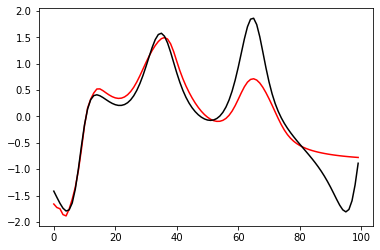

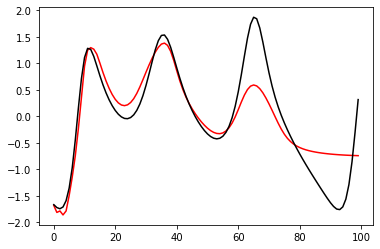

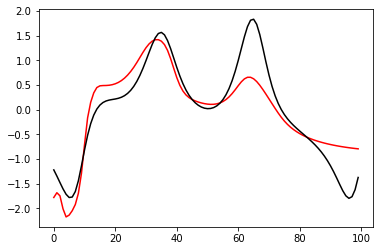

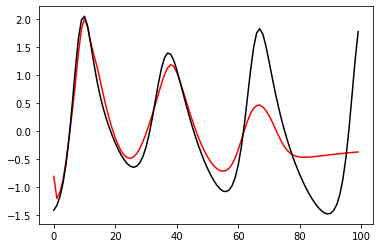

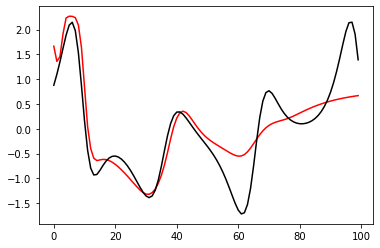

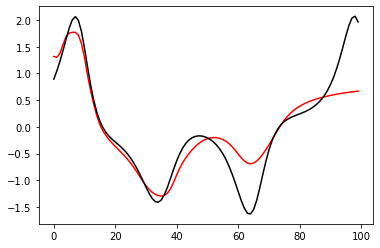

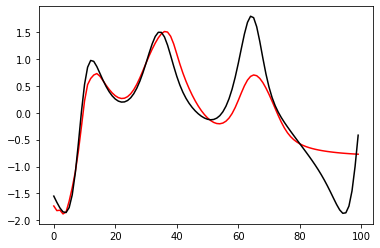

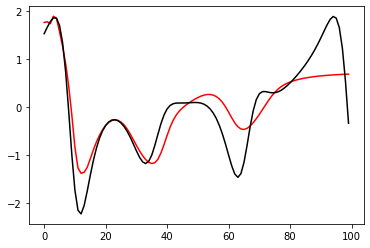

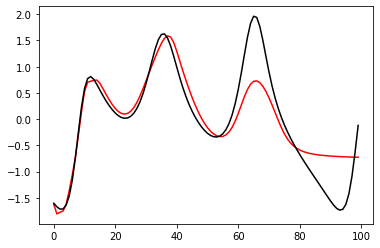

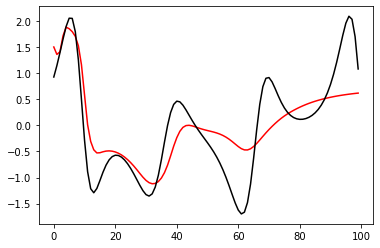

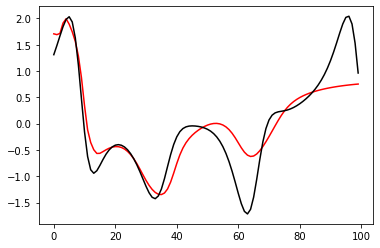

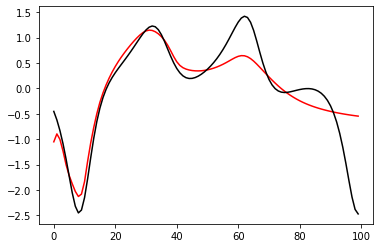

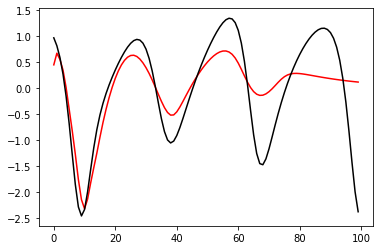

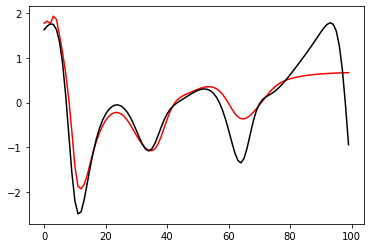

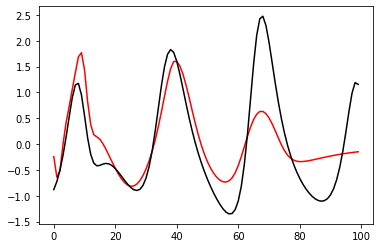

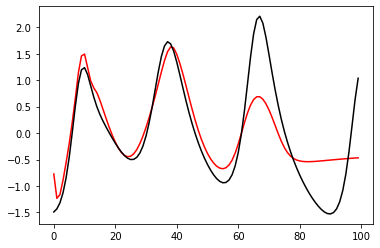

In [18]:
for i in range(neuron_num):
    plt.figure()
    plt.plot(vae(x_batch_train)[0,:,i],"r")
    plt.plot(output[0,:,i],'k')
    #plt.plot(x_batch_train[0,:,i],'b')

# Evaluate Quality of reconstruction 

(1, 100, 50)
(1, 100, 3)
(100, 3)
(100, 3)


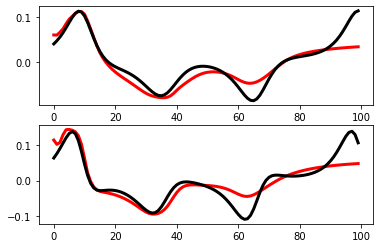

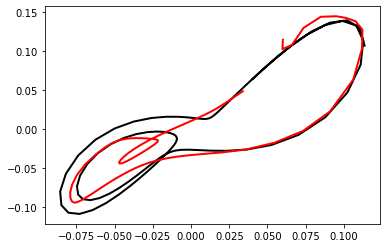

In [16]:
for x in batched_dataset.take(1):
    print(x.shape)
    qz_mean_est = vae.latent(x)
    print(qz_mean_est.shape)

qz_est_norm = np.stack(qz_mean_est)/np.linalg.norm(np.stack(qz_mean_est))
print(qz_est_norm[0].shape)

z_true_c = traj - traj.mean(axis=0)
z_true_norm = z_true_c/np.linalg.norm(z_true_c)
print(z_true_norm.shape)
R = funs.compute_optimal_rotation(np.stack(qz_est_norm[0]), z_true_norm, scale=True)
qz_est_norm_R = np.stack(qz_est_norm).dot(R)

from scipy import signal
#qz_est_norm_R[:,0] = signal.savgol_filter(qz_est_norm_R[:,0], 51, 5)
#qz_est_norm_R[:,1] = signal.savgol_filter(qz_est_norm_R[:,1],51, 5)
plt.subplot(211)
plt_post = plt.plot(qz_est_norm_R[0,:,0],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,0], 'k', linewidth = 3, label = '\"true\" mean')
plt.subplot(212)
plt_post = plt.plot(qz_est_norm_R[0,:,1],'r', linewidth = 3, label = 'posterior mean')
plt_true = plt.plot(z_true_norm[:,1], 'k', linewidth = 3, label = '\"true\" mean')

fig = plt.figure()
plt.plot(z_true_norm[:,0], z_true_norm[:,1], lw=2, color = 'k')
plt.plot(qz_est_norm_R[0,:,0], qz_est_norm_R[0,:,1], lw=2, color = 'r')